TODO Notes:
1. add promo moving average or lags - initial indicators are they are not correlated.
2. do parameter tuning, Done.
3. do cross-train - done, reduced accuracy.
4. create interaction terms - payday and weekday interaction, etc. 
5. Holidays and events relationship 
6. add multi-step forecasting 
7. seperate models for 1. Grocery I 2. Beverages 3. every other family 
8. seperate seasonality data for grocery and beverages category. 
9. expanding window features - cumulative 
10. exponential weighted moving average 
11. local holiday for a state is in the test dataset.

In [126]:
import xgboost as xgb, duckdb as db 
from sklearn.metrics import mean_squared_log_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import plotly.express as pe 
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go
from pathlib import Path
from warnings import simplefilter
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import MSTL, DecomposeResult
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier, Seasonality, TimeTrend
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

TODO:
1. handle outliers from earthquake period - for grocery I reduce to 8k if value greater than that.

In [127]:
def handle_outliers(data):
    condition = (data['family'] == 'GROCERY I') & (data['date'].dt.year == 2016) & (data['date'].dt.month == 4)
    data.loc[condition, 'sales'] = 4500
    return data

In [128]:
df = pd.read_csv('train.csv', parse_dates=['date'], dtype={
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
})
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['quarter'] = df['date'].dt.quarter
df['weekofyear'] = df['date'].dt.isocalendar().week
df['date_ordinal'] = df['date'].map(pd.Timestamp.toordinal)
df['sales'] = df['sales'].astype(np.int32)
df = handle_outliers(df)
df = df.set_index('date').to_period('D')
df = df.set_index(['store_nbr','family'], append=True)
df

id  sales  onpromotion  \
date       store_nbr family                                                    
2013-01-01 1         AUTOMOTIVE                        0      0            0   
                     BABY CARE                         1      0            0   
                     BEAUTY                            2      0            0   
                     BEVERAGES                         3      0            0   
                     BOOKS                             4      0            0   
...                                                  ...    ...          ...   
2017-08-15 9         POULTRY                     3000883    438            0   
                     PREPARED FOODS              3000884    154            1   
                     PRODUCE                     3000885   2419          148   
                     SCHOOL AND OFFICE SUPPLIES  3000886    121            8   
                     SEAFOOD                     3000887     16            0   

                                                 month  year  day_of_week  \
date       store_nbr family                                                 
2013-01-01 1         AUTOMOTIVE                      1  2013            1   
                     BABY CARE                       1  2013            1   
                     BEAUTY                          1  2013            1   
                     BEVERAGES                       1  2013            1   
                     BOOKS                           1  2013            1   
...                                                ...   ...          ...   
2017-08-15 9         POULTRY                         8  2017            1   
                     PREPARED FOODS                  8  2017            1   
                     PRODUCE                         8  2017            1   
                     SCHOOL AND OFFICE SUPPLIES      8  2017            1   
                     SEAFOOD                         8  2017            1   

                                                 day_of_month  quarter  \
date       store_nbr family                                              
2013-01-01 1         AUTOMOTIVE                             1        1   
                     BABY CARE                              1        1   
                     BEAUTY                                 1        1   
                     BEVERAGES                              1        1   
                     BOOKS                                  1        1   
...                                                       ...      ...   
2017-08-15 9         POULTRY                               15        3   
                     PREPARED FOODS                        15        3   
                     PRODUCE                               15        3   
                     SCHOOL AND OFFICE SUPPLIES            15        3   
                     SEAFOOD                               15        3   

                                                 weekofyear  date_ordinal  
date       store_nbr family                                                
2013-01-01 1         AUTOMOTIVE                           1        734869  
                     BABY CARE                            1        734869  
                     BEAUTY                               1        734869  
                     BEVERAGES                            1        734869  
                     BOOKS                                1        734869  
...                                                     ...           ...  
2017-08-15 9         POULTRY                             33        736556  
                     PREPARED FOODS                      33        736556  
                     PRODUCE                             33        736556  
                     SCHOOL AND OFFICE SUPPLIES          33        736556  
                     SEAFOOD                             33        736556  

[3000888 rows x 10 columns]

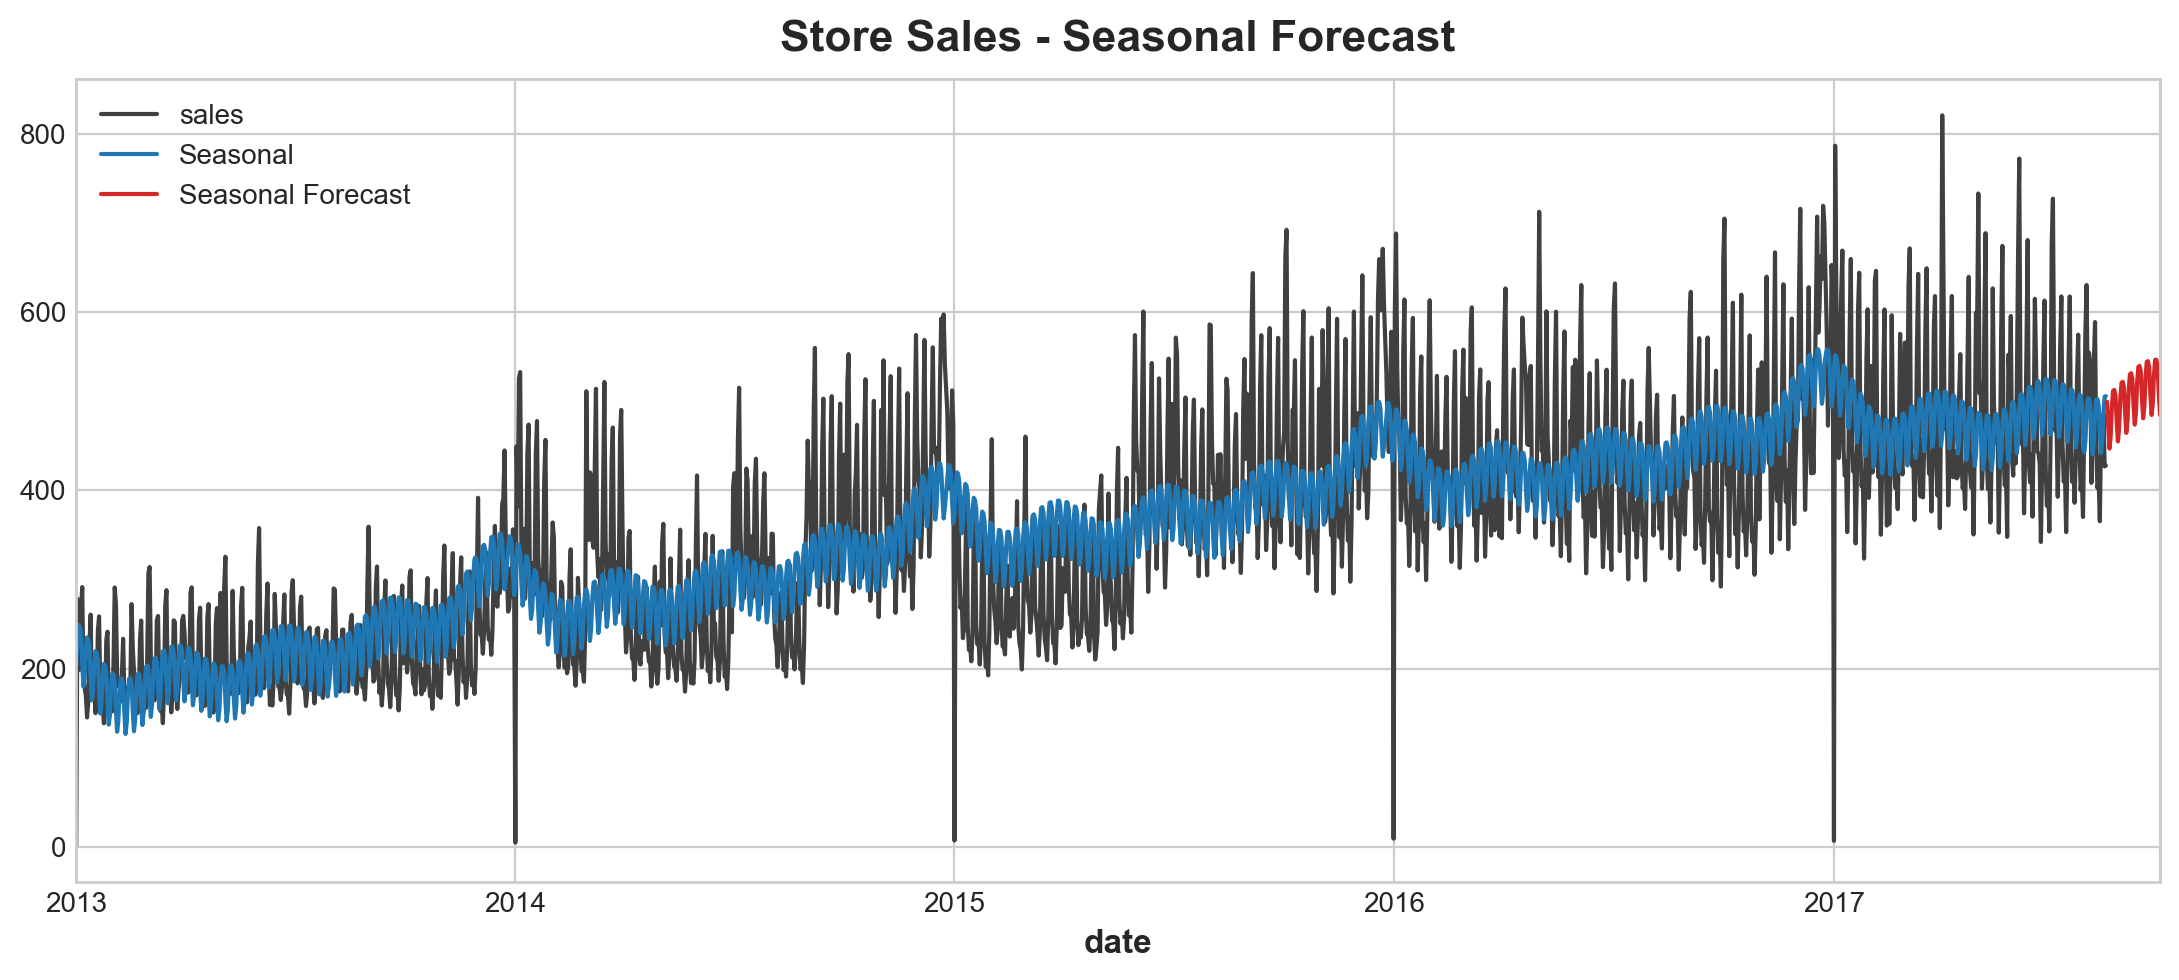

In [129]:
average_sales = df.groupby(['date']).mean()['sales']
y = average_sales
fourier = Fourier(period=365.25, order=4)
weekly_seasonality = Seasonality(period=7)
dp = DeterministicProcess(
    index = y.index,
    constant= False,
    order = 2,
    additional_terms=[fourier, weekly_seasonality],    
    drop=True
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
average_sales_trend = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
average_sales_trend_forecast = dp.out_of_sample(steps=45)

model = LinearRegression(fit_intercept=False)
_ = model.fit(average_sales_trend,y)

y_pred = pd.Series(model.predict(average_sales_trend), index=y.index)
X_fore = average_sales_trend_forecast
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25',  title="Store Sales - Seasonal Forecast", )
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

#TODO: change the chart to use plotly 

In [130]:
seasonal_df = pd.concat([average_sales_trend, average_sales_trend_forecast]).drop(columns=['trend_squared']).reset_index().rename(columns={'index':'date'})
seasonal_df['date'] = seasonal_df['date'].dt.to_timestamp()
seasonal_df

,date,trend,"sin(1,365.25)","cos(1,365.25)","sin(2,365.25)","cos(2,365.25)","sin(3,365.25)","cos(3,365.25)","sin(4,365.25)","cos(4,365.25)","s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)"
0,2013-01-01,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-02,2.0,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-03,3.0,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2013-01-04,4.0,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2013-01-05,5.0,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,2017-09-25,1725.0,-0.982352,-0.187043,0.367485,-0.930030,0.844881,0.534955,-0.683543,0.729910,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1725,2017-09-26,1726.0,-0.985424,-0.170118,0.335276,-0.942120,0.871351,0.490660,-0.631740,0.775180,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1726,2017-09-27,1727.0,-0.988204,-0.153142,0.302670,-0.953095,0.895501,0.445059,-0.576948,0.816781,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1727,2017-09-28,1728.0,-0.990692,-0.136120,0.269707,-0.962943,0.917267,0.398272,-0.519424,0.854517,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [131]:
#serial dependence
grouped = df.groupby(level=['store_nbr','family'], as_index=False)
def create_lag_features(group, lags):
    for lag in lags:
        group[f'sales_lag_{lag}'] = group['sales'].shift(lag)
    return group
lags_df = grouped.apply(lambda x: create_lag_features(x, [28]))
#lags_df.drop(columns=['sales_lag_4','sales_lag_8','sales_lag_9','sales_lag_10','sales_lag_11','sales_lag_12', 'sales_lag_13'], inplace=True,)
lags_df.fillna(0, inplace=True)
lags_df = lags_df.reset_index().drop(columns='level_0')
lags_df['date'] = lags_df['date'].dt.to_timestamp()
lags_df

,date,store_nbr,family,id,sales,onpromotion,month,year,day_of_week,day_of_month,quarter,weekofyear,date_ordinal,sales_lag_28
0,2013-01-01,1,AUTOMOTIVE,0,0,0,1,2013,1,1,1,1,734869,0.0
1,2013-01-02,1,AUTOMOTIVE,1782,2,0,1,2013,2,2,1,1,734870,0.0
2,2013-01-03,1,AUTOMOTIVE,3564,3,0,1,2013,3,3,1,1,734871,0.0
3,2013-01-04,1,AUTOMOTIVE,5346,3,0,1,2013,4,4,1,1,734872,0.0
4,2013-01-05,1,AUTOMOTIVE,7128,5,0,1,2013,5,5,1,1,734873,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-11,9,SEAFOOD,2993759,23,0,8,2017,4,11,3,32,736552,15.0
3000884,2017-08-12,9,SEAFOOD,2995541,16,4,8,2017,5,12,3,32,736553,35.0
3000885,2017-08-13,9,SEAFOOD,2997323,20,0,8,2017,6,13,3,32,736554,18.0
3000886,2017-08-14,9,SEAFOOD,2999105,17,0,8,2017,0,14,3,33,736555,10.0


In [132]:
oil_df = pd.read_csv('oil_updated.csv')
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df['dcoilwtico'].ffill(inplace=True)
oil_df['lag_90d_avg_oil_price_1'] = oil_df['90d_avg_oil_price'].shift(1)
oil_df['lag_90d_avg_oil_price_2'] = oil_df['90d_avg_oil_price'].shift(2)
oil_df['lag_90d_avg_oil_price_3'] = oil_df['90d_avg_oil_price'].shift(3)
oil_df['lag_90d_avg_oil_price_4'] = oil_df['90d_avg_oil_price'].shift(4)
oil_df['lag_90d_avg_oil_price_1'].ffill(inplace=True)
oil_df['lag_90d_avg_oil_price_2'].ffill(inplace=True)
oil_df['lag_90d_avg_oil_price_3'].ffill(inplace=True)
oil_df['lag_90d_avg_oil_price_4'].ffill(inplace=True)

In [133]:
df_holidays = pd.read_csv('holidays_events.csv', date_parser=['date'])
df_holidays = db.sql("""
    select h.*
       , case when h.type NOT IN ('Work Day', 'Event') AND locale ='Local' THEN 1 ELSE 0 END "is_local_holiday"
       , case when h.type NOT IN ('Work Day', 'Event') AND locale ='National' THEN 1 ELSE 0 END "is_national_holiday"
       , case when h.type NOT IN ('Work Day', 'Event') AND locale ='National' THEN 1 ELSE 0 END "is_holiday"
       , case when h.type = 'Event' THEN 1 ELSE 0 END "is_event" 
    from df_holidays h
""").df()
# db.sql("""
#     select *, lead(is_local_holiday) OVER (order by date::date asc) from df_holidays
#  """).df().tail(30)
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays

,date,type,locale,locale_name,description,transferred,is_local_holiday,is_national_holiday,is_holiday,is_event
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1,0,0,0
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,0,0,0,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1,0,0,0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0,0,0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,0,1,1,0
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,0,1,1,0
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,0,1,1,0
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,0,1,1,0


In [134]:
features = df.reset_index()

features['date'] = features['date'].dt.to_timestamp()
features = features.merge(seasonal_df, how='left', on='date')
features["date"] = pd.to_datetime(features["date"])
features = features.merge(lags_df.reset_index(), how='left', on=['date','store_nbr','family'])[['date', 'store_nbr', 'family', 'id_x', 'sales_x', 'onpromotion_x',
       'month_x', 'year_x', 'day_of_week_x', 'day_of_month_x', 'quarter_x',
       'weekofyear_x', 'date_ordinal_x', 'trend', 'sin(1,365.25)',
       'cos(1,365.25)', 'sin(2,365.25)', 'cos(2,365.25)', 'sin(3,365.25)',
       'cos(3,365.25)', 'sin(4,365.25)', 'cos(4,365.25)', 's(1,7)', 's(2,7)',
       's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 'sales_lag_28']]
features = features.merge(oil_df, on='date')[['date', 'store_nbr', 'family'
       , 'id_x', 'sales_x', 'onpromotion_x', 'month_x', 'year_x', 'day_of_week_x', 'day_of_month_x', 'quarter_x',
       'weekofyear_x', 'date_ordinal_x', 'trend', 'sin(1,365.25)',
       'cos(1,365.25)', 'sin(2,365.25)', 'cos(2,365.25)', 'sin(3,365.25)',
       'cos(3,365.25)', 'sin(4,365.25)', 'cos(4,365.25)', 's(1,7)', 's(2,7)',
       's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 'sales_lag_28'
       ,'dcoilwtico','90d_avg_oil_price','lag_90d_avg_oil_price_1', 'lag_90d_avg_oil_price_2', 'lag_90d_avg_oil_price_3', 'lag_90d_avg_oil_price_4']].rename(columns={'sales_x':'sales', 'date_ordinal_x':'date_ordinal'})
features = features.merge(df_holidays, on='date', how='left')[['date', 'store_nbr', 'family'
       , 'id_x', 'sales', 'onpromotion_x', 'month_x', 'year_x', 'day_of_week_x', 'day_of_month_x', 'quarter_x',
       'weekofyear_x', 'date_ordinal', 'trend', 'sin(1,365.25)',
       'cos(1,365.25)', 'sin(2,365.25)', 'cos(2,365.25)', 'sin(3,365.25)',
       'cos(3,365.25)', 'sin(4,365.25)', 'cos(4,365.25)', 's(1,7)', 's(2,7)',
       's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)','dcoilwtico', 'sales_lag_28'
       ,'lag_90d_avg_oil_price_1', 'lag_90d_avg_oil_price_2', 'lag_90d_avg_oil_price_3', 'lag_90d_avg_oil_price_4'
       ,'90d_avg_oil_price' ,'is_holiday', 'is_national_holiday', 'is_local_holiday' ,'is_event'
       ]]

In [135]:
features = db.sql("""
    select *
       , avg(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ASC RANGE BETWEEN INTERVAL 41 DAYS PRECEDING AND CURRENT ROW) "rolling_avg_sales_42"  
       , avg(sales) OVER (PARTITION BY store_nbr, family ORDER BY date ASC RANGE BETWEEN INTERVAL 27 DAYS PRECEDING AND CURRENT ROW) "rolling_avg_sales_28"  
       from features f              
       order by store_nbr, date 
 """).df()
features['is_holiday'] = features['is_holiday'].fillna(0)
features['is_local_holiday'] = features['is_local_holiday'].fillna(0)
features['is_national_holiday'] = features['is_national_holiday'].fillna(0)
features['is_event'] = features['is_event'].fillna(0)
features

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,date,store_nbr,family,id_x,sales,onpromotion_x,month_x,year_x,day_of_week_x,day_of_month_x,...,lag_90d_avg_oil_price_2,lag_90d_avg_oil_price_3,lag_90d_avg_oil_price_4,90d_avg_oil_price,is_holiday,is_national_holiday,is_local_holiday,is_event,rolling_avg_sales_42,rolling_avg_sales_28
0,2013-01-01,1,SCHOOL AND OFFICE SUPPLIES,31,0,0,1,2013,1,1,...,NaN,NaN,NaN,0.000000,1.0,1.0,0.0,0.0,0.000000,0.000000
1,2013-01-01,1,SEAFOOD,32,0,0,1,2013,1,1,...,NaN,NaN,NaN,0.000000,1.0,1.0,0.0,0.0,0.000000,0.000000
2,2013-01-01,1,MEATS,24,0,0,1,2013,1,1,...,NaN,NaN,NaN,0.000000,1.0,1.0,0.0,0.0,0.000000,0.000000
3,2013-01-01,1,BEAUTY,2,0,0,1,2013,1,1,...,NaN,NaN,NaN,0.000000,1.0,1.0,0.0,0.0,0.000000,0.000000
4,2013-01-01,1,POULTRY,28,0,0,1,2013,1,1,...,NaN,NaN,NaN,0.000000,1.0,1.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,DELI,3000864,551,7,8,2017,1,15,...,47.033846,47.023077,47.012308,47.030659,0.0,0.0,1.0,0.0,560.523810,547.142857
3054344,2017-08-15,9,HOME APPLIANCES,3000872,0,0,8,2017,1,15,...,47.033846,47.023077,47.012308,47.030659,0.0,0.0,1.0,0.0,0.119048,0.000000
3054345,2017-08-15,9,DAIRY,3000863,835,19,8,2017,1,15,...,47.033846,47.023077,47.012308,47.030659,0.0,0.0,1.0,0.0,818.904762,798.678571
3054346,2017-08-15,9,GROCERY II,3000868,9,0,8,2017,1,15,...,47.033846,47.023077,47.012308,47.030659,0.0,0.0,1.0,0.0,12.452381,12.428571


In [136]:
df_train = features.query("date<'2017-08-01'")
df_train["test"] = 0  
df_validation = features.query("date>='2017-08-01'")
df_validation["test"] = 1 
df_validation 


,date,store_nbr,family,id_x,sales,onpromotion_x,month_x,year_x,day_of_week_x,day_of_month_x,...,lag_90d_avg_oil_price_3,lag_90d_avg_oil_price_4,90d_avg_oil_price,is_holiday,is_national_holiday,is_local_holiday,is_event,rolling_avg_sales_42,rolling_avg_sales_28,test
56067,2017-08-01,1,SCHOOL AND OFFICE SUPPLIES,2974189,0,0,8,2017,1,1,...,46.702088,46.697582,46.726264,0.0,0.0,0.0,0.0,0.000000,0.000000,1
56068,2017-08-01,1,SEAFOOD,2974190,33,0,8,2017,1,1,...,46.702088,46.697582,46.726264,0.0,0.0,0.0,0.0,24.222222,25.035714,1
56069,2017-08-01,1,MEATS,2974182,336,0,8,2017,1,1,...,46.702088,46.697582,46.726264,0.0,0.0,0.0,0.0,300.000000,306.214286,1
56070,2017-08-01,1,BEAUTY,2974160,4,0,8,2017,1,1,...,46.702088,46.697582,46.726264,0.0,0.0,0.0,0.0,3.644444,3.107143,1
56071,2017-08-01,1,POULTRY,2974186,312,0,8,2017,1,1,...,46.702088,46.697582,46.726264,0.0,0.0,0.0,0.0,323.733333,340.857143,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,DELI,3000864,551,7,8,2017,1,15,...,47.023077,47.012308,47.030659,0.0,0.0,1.0,0.0,560.523810,547.142857,1
3054344,2017-08-15,9,HOME APPLIANCES,3000872,0,0,8,2017,1,15,...,47.023077,47.012308,47.030659,0.0,0.0,1.0,0.0,0.119048,0.000000,1
3054345,2017-08-15,9,DAIRY,3000863,835,19,8,2017,1,15,...,47.023077,47.012308,47.030659,0.0,0.0,1.0,0.0,818.904762,798.678571,1
3054346,2017-08-15,9,GROCERY II,3000868,9,0,8,2017,1,15,...,47.023077,47.012308,47.030659,0.0,0.0,1.0,0.0,12.452381,12.428571,1


In [137]:
# Train the model
features_list = ['date_ordinal', 'store_nbr', 'family', 'onpromotion_x',
       'month_x', 'year_x', 'day_of_week_x', 'day_of_month_x', 'quarter_x',
       'weekofyear_x',  'trend', 'sin(1,365.25)',
       'cos(1,365.25)', 'sin(2,365.25)', 'cos(2,365.25)', 'sin(3,365.25)',
       'cos(3,365.25)', 'sin(4,365.25)', 'cos(4,365.25)', 's(1,7)', 's(2,7)',
       's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 'dcoilwtico', 'sales_lag_28'
       ,'90d_avg_oil_price', 'lag_90d_avg_oil_price_1', 'lag_90d_avg_oil_price_2', 'lag_90d_avg_oil_price_3', 'lag_90d_avg_oil_price_4'
       , 'rolling_avg_sales_28' 
       ] #'is_holiday', 'is_national_holiday', 'is_local_holiday' , 'rolling_avg_sales_42' , 'is_local_holiday'

# validation_date = '2017-08-01'
# train_set = df_train.query("test==0 and date<='2017-07-15'").drop(columns='test')  #whole_merged[whole_merged['date'] < validation_date].drop(columns='test')
# validation_set = df_train.query("test==0 and date>'2017-07-15'").drop(columns='test') #whole_merged[whole_merged['date'] >= validation_date].drop(columns='test')

X_train = df_train[features_list]
y_train = df_train['sales']
X_val = df_validation[features_list]
y_val = df_validation['sales']

#validation_set#.query("date>='2017-08-01'")

model = xgb.XGBRegressor(objective='reg:linear', n_estimators=500
                         , learning_rate=0.1, eval_metric='rmsle'
                         , early_stopping_rounds=25, enable_categorical=True
                         #, interaction_constraints = [['is_holiday', 'is_national_holiday', 'is_local_holiday']]
                         )
model.fit(X_train, y_train, eval_set=[(df_validation[features_list], df_validation['sales'])], verbose=False) 

# Evaluate the model against validation dataset 
y_pred = model.predict(X_val)
y_pred = np.where(y_pred < 0, 0, y_pred) 
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
print(f'Validation RMSLE: {rmsle}')

Validation RMSLE: 0.5567778266831249


In [138]:
# features = features.set_index('date').to_period('D')
# features = features.set_index(['store_nbr','family'], append=True)
# features.to_csv('features.csv')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

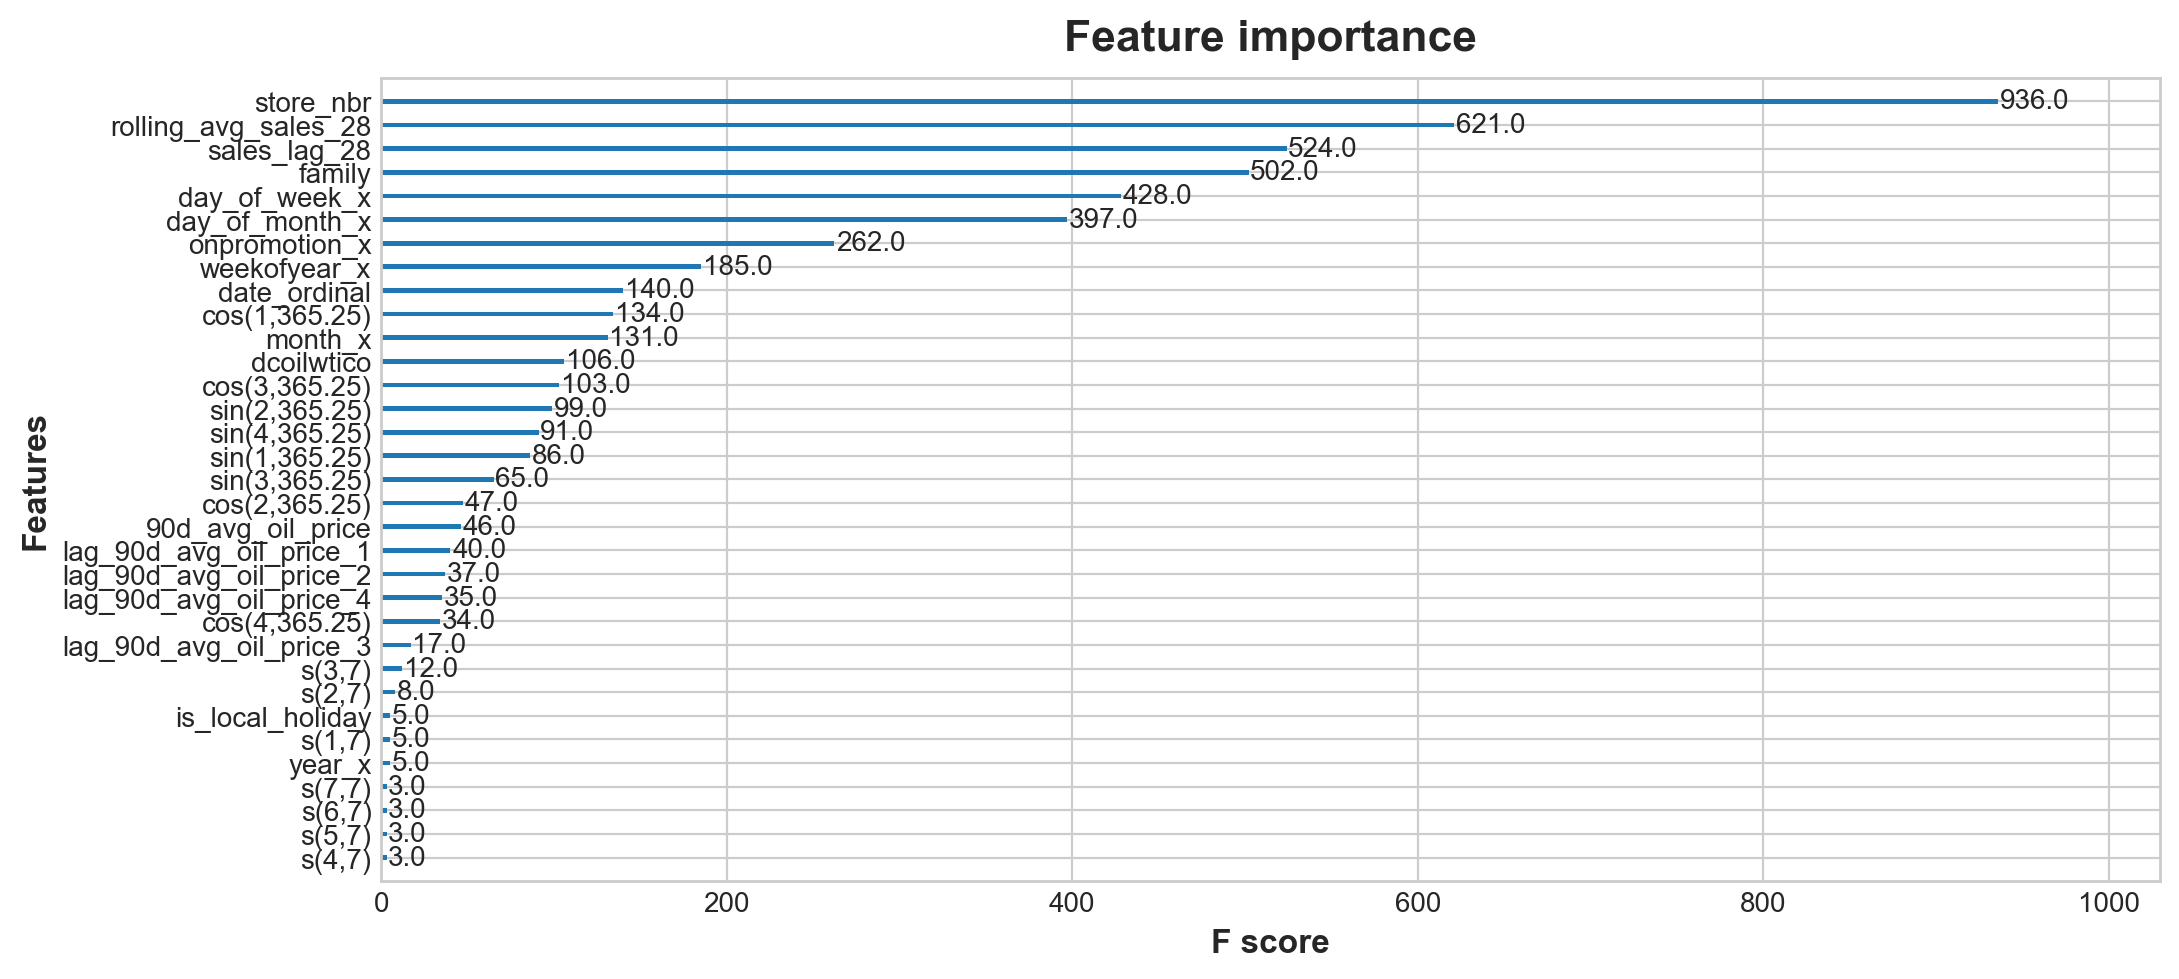

In [139]:
plot_importance(model)

In [140]:
#plot_importance(model)

In [141]:
#include train plus validation data and retrain model 

X_train = features[features_list]
y_train = features['sales']

model = xgb.XGBRegressor(objective='reg:squarederror'
                         , n_estimators=500
                         , learning_rate=0.1
                         , eval_metric='rmsle'
                         , enable_categorical=True)
model.fit(X_train, y_train, verbose=True)
#xgb.train(dtrain=X_train, evals=y_train, )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [142]:
# # Hyperparameter tuning

# tscv = TimeSeriesSplit(n_splits=5)

# param_dist = {
#     'n_estimators': [300, 500, 1000],
#     'learning_rate': [0.1, 0.15, 0.2],
#     'max_depth': [5, 7, 10] 
#     #'reg_alpha': [0, 0.1, 0.5],
#     #'reg_lambda': [1, 1.5, 2]
# }

# X_train = features[features_list]
# y_train = features['sales']

# model = xgb.XGBRegressor(objective='reg:squarederror'                         
#                          , eval_metric='rmsle'
#                          , enable_categorical=True)

# random_search = RandomizedSearchCV(
#     estimator=model, 
#     param_distributions=param_dist, 
#     n_iter=20, 
#     cv=tscv, 
#     scoring='neg_mean_squared_log_error', 
#     verbose=1, 
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)

# # Best hyperparameters
# best_params = random_search.best_params_
# print(f'Best parameters found: {best_params}')
# #Best parameters found: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}

In [143]:
#add features for test.csv data 
df_test = pd.read_csv('train.csv', parse_dates=['date'], dtype={
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
})
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year
df_test['day_of_week'] = df_test['date'].dt.dayofweek
df_test['day_of_month'] = df_test['date'].dt.day
df_test['quarter'] = df_test['date'].dt.quarter
df_test['weekofyear'] = df_test['date'].dt.isocalendar().week
df_test['date_ordinal'] = df_test['date'].map(pd.Timestamp.toordinal)
df_test['sales'] = df_test['sales'].astype(np.int32)
df_test = df_test.set_index('date').to_period('D')
df_test = df_test.set_index(['store_nbr','family'], append=True)
test_set = pd.read_csv('test.csv', parse_dates=['date'], dtype={
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
})
test_set["date"] = pd.to_datetime(test_set['date'])
test_set['month'] = test_set['date'].dt.month
test_set['year'] = test_set['date'].dt.year
test_set['day_of_week'] = test_set['date'].dt.dayofweek
test_set['day_of_month'] = test_set['date'].dt.day
test_set['quarter'] = test_set['date'].dt.quarter
test_set['weekofyear'] = test_set['date'].dt.isocalendar().week
test_set['date_ordinal'] = test_set['date'].map(pd.Timestamp.toordinal)
test_set['sales'] = 0 # test_set['sales'].astype(np.int32)
test_set = test_set.set_index('date').to_period('D')
test_set = test_set.set_index(['store_nbr','family'], append=True)

grouped = pd.concat([df_test, test_set])
test_set.reset_index(inplace=True)
test_set['date'] = test_set['date'].dt.to_timestamp()
grouped = grouped.groupby(level=['store_nbr','family'], as_index=False)
def create_lag_features(group, lags):
    for lag in lags:
        group[f'sales_lag_{lag}'] = group['sales'].shift(lag)
    return group
lags_df = grouped.apply(lambda x: create_lag_features(x, [28, 61]))
lags_df.reset_index(inplace=True)
lags_df['date'] = lags_df['date'].dt.to_timestamp()
lags_df['sales_lag_28'] = lags_df['sales_lag_28'].fillna(0)

def create_rolling_features(df):    
    result = db.sql("""
    select *       
       , avg(sales) OVER (PARTITION BY store_nbr, family ORDER BY date::date ASC RANGE BETWEEN INTERVAL 27 DAYS PRECEDING AND CURRENT ROW) "rolling_avg_sales_28"  
    from df f              
    order by date, store_nbr
    """).df()
    #result["date"] = result["date"].dt.to_timestamp()
    return result
rolling_df = create_rolling_features(pd.concat([df.reset_index(), df_test.reset_index(), test_set.reset_index()]))
#display(rolling_df)

test_set = test_set.merge(seasonal_df, on='date', how='left')
test_set = test_set.merge(lags_df.reset_index(), on=['date','store_nbr','family'])[['date', 'store_nbr', 'family', 'id_x', 'sales_x', 'onpromotion_x',
       'month_x', 'year_x', 'day_of_week_x', 'day_of_month_x', 'quarter_x',
       'weekofyear_x', 'date_ordinal_x', 'trend', 'sin(1,365.25)',
       'cos(1,365.25)', 'sin(2,365.25)', 'cos(2,365.25)', 'sin(3,365.25)',
       'cos(3,365.25)', 'sin(4,365.25)', 'cos(4,365.25)', 's(1,7)', 's(2,7)',
       's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 'sales_lag_28']]
test_set = test_set.merge(oil_df.reset_index(), on='date', how='left')[['date', 'store_nbr', 'family'
       , 'id_x', 'sales_x', 'onpromotion_x', 'month_x', 'year_x', 'day_of_week_x', 'day_of_month_x', 'quarter_x',
       'weekofyear_x', 'date_ordinal_x', 'trend', 'sin(1,365.25)',
       'cos(1,365.25)', 'sin(2,365.25)', 'cos(2,365.25)', 'sin(3,365.25)',
       'cos(3,365.25)', 'sin(4,365.25)', 'cos(4,365.25)', 's(1,7)', 's(2,7)',
       's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)','dcoilwtico', 'sales_lag_28',
       '90d_avg_oil_price','lag_90d_avg_oil_price_1', 'lag_90d_avg_oil_price_2', 'lag_90d_avg_oil_price_3', 'lag_90d_avg_oil_price_4'
       ]].rename(columns={'sales_x':'sales', 'date_ordinal_x':'date_ordinal'})
test_set = test_set.merge(df_holidays, on='date', how='left')[['date', 'store_nbr', 'family'
       , 'id_x', 'sales', 'onpromotion_x', 'month_x', 'year_x', 'day_of_week_x', 'day_of_month_x', 'quarter_x',
       'weekofyear_x', 'date_ordinal', 'trend', 'sin(1,365.25)',
       'cos(1,365.25)', 'sin(2,365.25)', 'cos(2,365.25)', 'sin(3,365.25)',
       'cos(3,365.25)', 'sin(4,365.25)', 'cos(4,365.25)', 's(1,7)', 's(2,7)',  'sales_lag_28',
       's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)'
       ,'dcoilwtico','90d_avg_oil_price','lag_90d_avg_oil_price_1', 'lag_90d_avg_oil_price_2', 'lag_90d_avg_oil_price_3', 'lag_90d_avg_oil_price_4'
       , 'is_local_holiday'
       ]] #, 'is_holiday', 'is_national_holiday', 'is_local_holiday'
test_set = db.sql("""
    select * from test_set t 
    left join rolling_df r on r.date::date = t.date::date and r.store_nbr = t.store_nbr and r.family=t.family
 """).df()
test_set

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,date,store_nbr,family,id_x,sales,onpromotion_x,month_x,year_x,day_of_week_x,day_of_month_x,...,onpromotion,month,year,day_of_week,day_of_month,quarter,weekofyear,date_ordinal_1,index,rolling_avg_sales_28
0,2017-08-16,1,POULTRY,3000916,0,0,8,2017,2,16,...,0,8,2017,2,16,3,33,736557,28.0,294.545455
1,2017-08-16,1,HOME APPLIANCES,3000905,0,0,8,2017,2,16,...,0,8,2017,2,16,3,33,736557,17.0,0.509091
2,2017-08-16,1,LAWN AND GARDEN,3000908,0,16,8,2017,2,16,...,16,8,2017,2,16,3,33,736557,20.0,18.581818
3,2017-08-16,1,BEAUTY,3000890,0,2,8,2017,2,16,...,2,8,2017,2,16,3,33,736557,2.0,3.272727
4,2017-08-16,1,HOME CARE,3000906,0,10,8,2017,2,16,...,10,8,2017,2,16,3,33,736557,18.0,167.163636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,54,BREAD/BAKERY,3029240,0,3,8,2017,3,31,...,3,8,2017,3,31,3,35,736572,28352.0,150.050000
28508,2017-08-31,54,PET SUPPLIES,3029261,0,0,8,2017,3,31,...,0,8,2017,3,31,3,35,736572,28373.0,0.000000
28509,2017-08-31,6,PET SUPPLIES,3029294,0,0,8,2017,3,31,...,0,8,2017,3,31,3,35,736572,28406.0,5.800000
28510,2017-08-31,8,SCHOOL AND OFFICE SUPPLIES,3029365,0,0,8,2017,3,31,...,0,8,2017,3,31,3,35,736572,28477.0,1.000000


In [144]:
# submission to kaggle
X_val = test_set[features_list] #test_set[df_train.columns] 
y_val = test_set['sales']

# Evaluate the model
test_set['prediction_label'] = model.predict(X_val)
test_set['prediction_label'] = test_set['prediction_label'].apply(lambda x: 0 if x<0 else x)
test_set[['id_x','prediction_label']].rename(columns={'prediction_label':'sales','id_x':'id'}).to_csv('submission.csv', index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

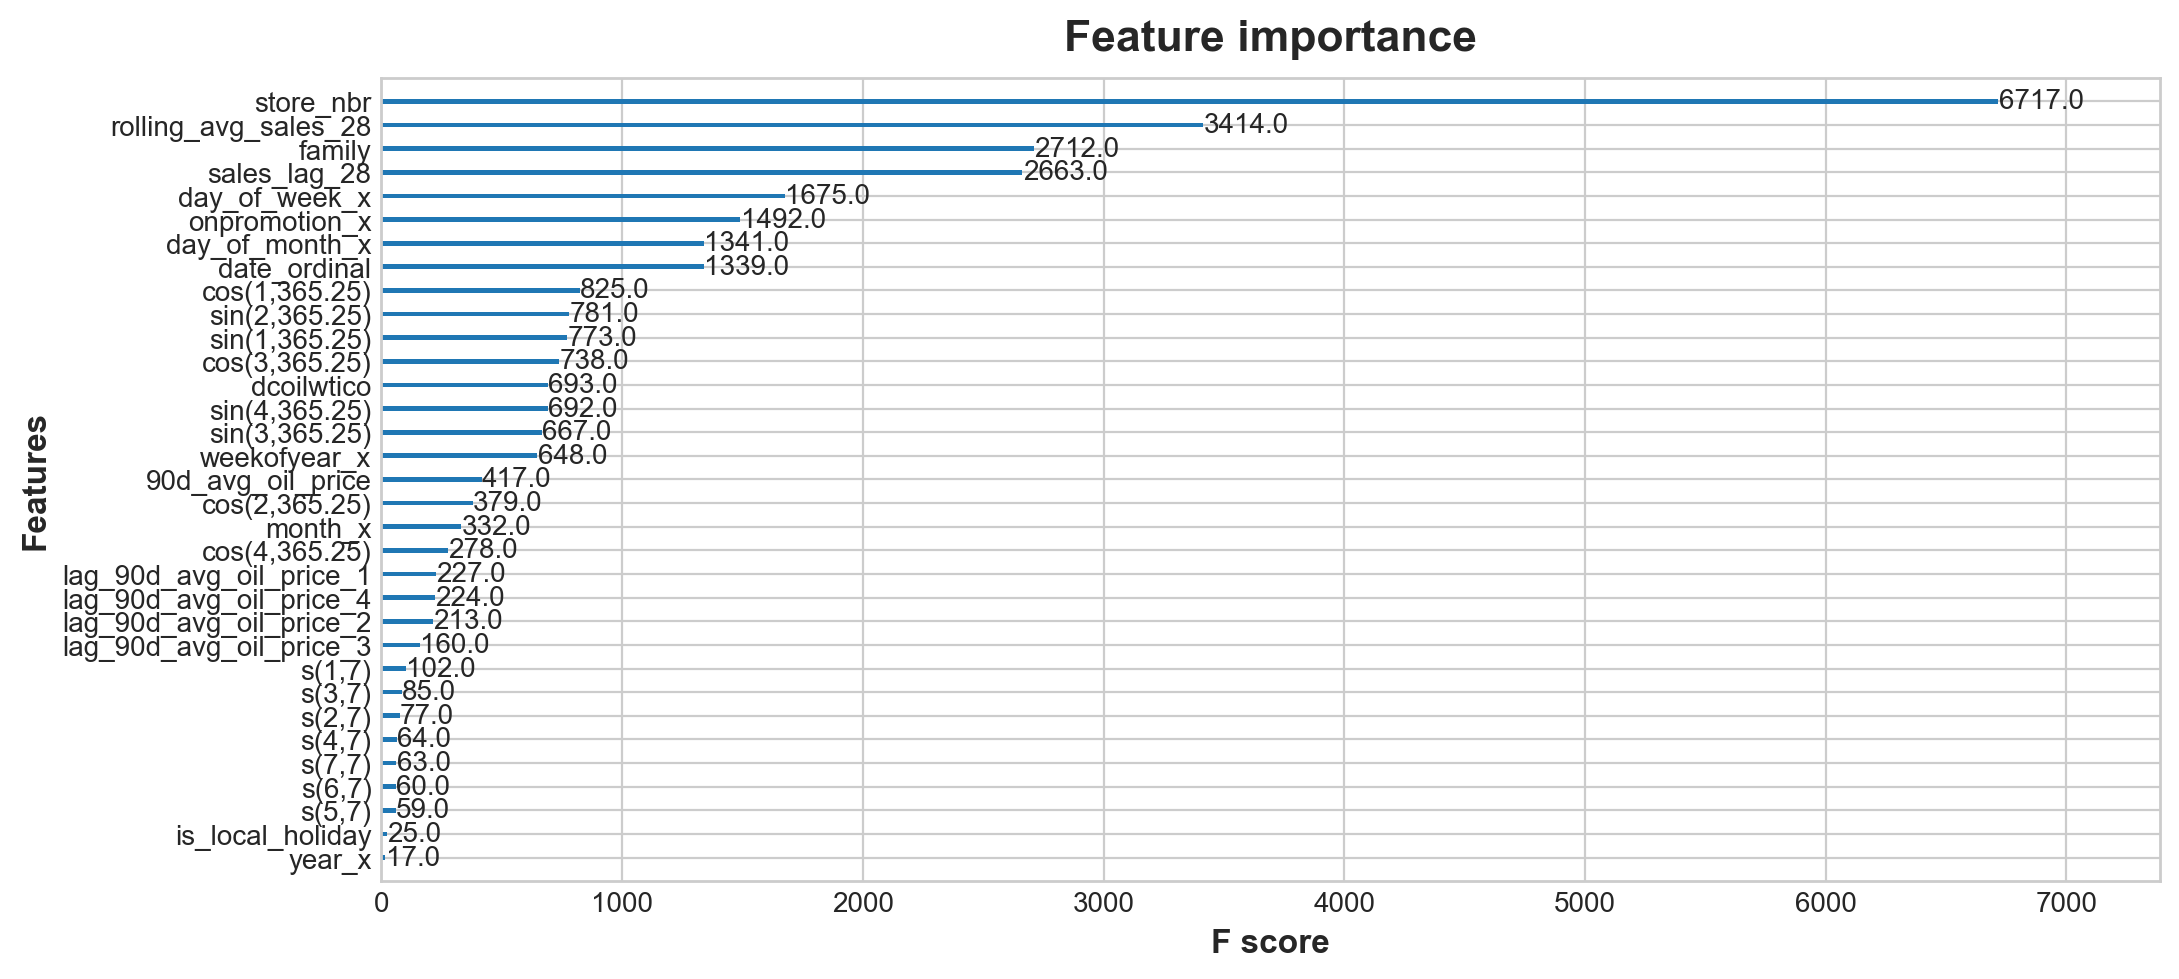

In [145]:
plot_importance(model)